# Analysis of my favourite youtube channel - Slayy point

## 1. Importing libraries

In [2]:
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
import numpy as np
from IPython.display import JSON

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2. Data creation with youtube API

In [4]:
api_key = 'xxxxxxxxxxxxxxxxxxxxxxx'

In [5]:
channel_ids = ["UCtgGOdTlM-NdJ9rPKIYN8UQ",
               # more channels here
              ]

In [6]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [14]:
def get_channel_stats(youtube, channel_ids):
    
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)
        
    return(pd.DataFrame(all_data))

def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids
    
    
def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

def get_comments_in_videos(youtube, video_ids):

    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)  

In [15]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [16]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,Slayy Point,7040000,1548803525,145,UUtgGOdTlM-NdJ9rPKIYN8UQ


In [17]:
playlist_id = "UUtgGOdTlM-NdJ9rPKIYN8UQ"

In [18]:
# Get video IDs
video_ids = get_video_ids(youtube, playlist_id)

In [19]:
# Get video details

video_df = get_video_details(youtube, video_ids)
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,DyHS2H05AQc,Slayy Point,Indian Vlogging Gone Insane,Start a Fixed Deposit on Groww and earn higher...,"[slayy point, abhyudaya, gautami, vlogs, india...",2022-06-15T14:10:27Z,8095885,634677,None,19801,PT13M11S,hd,true
1,D6qo8kSDlvE,Slayy Point,TV Serials Just Got Worse,Download Public App- https://bit.ly/publicapp_...,"[tv serials, tv serial roast, funny tv serial,...",2022-05-25T13:29:22Z,13524165,893807,None,27012,PT14M54S,hd,true
2,c1NYunE_4t4,Slayy Point,These Ads Are Spoiling TV! | IPL Ads,"IPL aagaya aur bekar ads bhi. Watch Kohli, Dho...","[slayy point, ipl, cricket, virat kohli, msd, ...",2022-05-04T14:05:11Z,9905763,698670,None,20711,PT12M38S,hd,true
3,t7gA1Qtl1wY,Slayy Point,Going to the RAINIEST Place on Earth | Rare Pl...,Iske saamne ab Mumbai ki baarish noob lagegi.....,"[slayy point, abhyudaya, gautami, slayy point ...",2022-04-19T13:34:46Z,11164516,728851,None,23686,PT21M,hd,true
4,mgrEg8hBJyU,Slayy Point,They Will Make You Cry in 1 Minute! | Emotiona...,Tired of crying. Thanks to YouTube Shorts Crea...,"[slayy point, youtube shorts, sad video, emoti...",2022-03-31T14:11:31Z,11343285,757142,None,27816,PT15M9S,hd,true


In [65]:
# Get comments details

comments_data = get_comments_in_videos(youtube, video_ids)
comments_df

Could not get comments for video DyHS2H05AQc


,video_id,comments
0,DyHS2H05AQc,[Download Groww app--- https://app.groww.in/v3...
1,D6qo8kSDlvE,[U GUYS ARE ACTUALLY TAKING IDEA FROM NISCHAY ...
2,c1NYunE_4t4,"[Omg hilarious 🤣, Ladki hai ki kutti - best, O..."
3,t7gA1Qtl1wY,[Happy Earth Day everyone!🌍\nPlease help us co...
4,mgrEg8hBJyU,[SUBSCRIBE-BUTTON TOUCHING VIDEO!\nToh jaldi s...
...,...,...
140,ZQxz3tRdlco,[Silly Point is now Slayy Point! A minor chang...
141,53IBdnidxtc,[Silly Point is now Slayy Point! A minor chang...
142,ircFZIzYlM8,[suddenly found this video ❤️❤️❤️❤️after slay ...
143,QBZPhIuDcNo,"[BINOD, Anand, 0:25 uncle op 😂\nBro \nIndian p..."


## 3. Data Preprocessing

In [20]:
#Checking for Nulls
video_df.isna().any()

video_id          False
channelTitle      False
title             False
description       False
tags              False
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [21]:
#dropping Favourite Column
video_df.drop(columns = 'favouriteCount')

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption
0,DyHS2H05AQc,Slayy Point,Indian Vlogging Gone Insane,Start a Fixed Deposit on Groww and earn higher...,"[slayy point, abhyudaya, gautami, vlogs, india...",2022-06-15T14:10:27Z,8095885,634677,19801,PT13M11S,hd,true
1,D6qo8kSDlvE,Slayy Point,TV Serials Just Got Worse,Download Public App- https://bit.ly/publicapp_...,"[tv serials, tv serial roast, funny tv serial,...",2022-05-25T13:29:22Z,13524165,893807,27012,PT14M54S,hd,true
2,c1NYunE_4t4,Slayy Point,These Ads Are Spoiling TV! | IPL Ads,"IPL aagaya aur bekar ads bhi. Watch Kohli, Dho...","[slayy point, ipl, cricket, virat kohli, msd, ...",2022-05-04T14:05:11Z,9905763,698670,20711,PT12M38S,hd,true
3,t7gA1Qtl1wY,Slayy Point,Going to the RAINIEST Place on Earth | Rare Pl...,Iske saamne ab Mumbai ki baarish noob lagegi.....,"[slayy point, abhyudaya, gautami, slayy point ...",2022-04-19T13:34:46Z,11164516,728851,23686,PT21M,hd,true
4,mgrEg8hBJyU,Slayy Point,They Will Make You Cry in 1 Minute! | Emotiona...,Tired of crying. Thanks to YouTube Shorts Crea...,"[slayy point, youtube shorts, sad video, emoti...",2022-03-31T14:11:31Z,11343285,757142,27816,PT15M9S,hd,true
...,...,...,...,...,...,...,...,...,...,...,...,...
140,ZQxz3tRdlco,Slayy Point,HOW MUCH MONEY DO WE MAKE?! *CLICK BAIT*,A casual 'Q & A' with you guys! :)\n\nWatch ou...,"[Silly Point breakdown, silly point q and a, s...",2017-04-05T08:21:51Z,2797605,170899,6697,PT9M8S,hd,false
141,53IBdnidxtc,Slayy Point,READING YOUTUBE COMMENTS | 10K SUBSCRIBERS (NO...,We go through some of your mean comments!\n\nF...,[Slayy Point],2016-12-31T06:17:29Z,3990128,227633,11884,PT3M54S,hd,false
142,ircFZIzYlM8,Slayy Point,MS Dhoni The Untold Story Trailer Public Revie...,Subscribe to Cookie Way : https://www.youtube....,"[MS Dhoni The Untold Story Movie Trailer, MS D...",2016-09-24T16:32:23Z,529350,24732,1251,PT4M1S,hd,false
143,QBZPhIuDcNo,Slayy Point,How Much Do People Know About The IPL? | PART ...,In this video we go around asking people some ...,"[Cricket, Quiz, Indians, IPL, Indian Premier L...",2016-04-27T15:46:39Z,552274,31610,1701,PT3M40S,hd,false


In [22]:
# Checking data types
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

###  Converting Data Types of Columns

In [78]:
Numeric = ['viewCount' , 'likeCount' , 'commentCount' ]
video_df[Numeric] = video_df[Numeric].astype('int64')

In [ ]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['publishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [70]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

### Adding new columns required for analysis

In [28]:
video_df['publishedMonth'] = video_df['publishedAt'].dt.month

In [29]:
video_df['publishedYear'] = video_df['publishedAt'].dt.year

In [58]:
video_df['titleLength'] = video_df['title'].apply(lambda x: len(x))

In [66]:
video_df['durationMin'] = video_df['durationSecs'] / 60

In [67]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [59]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishDayName,durationSecs,durationMin,tagCount,publishedMonth,publishedYear,titleLength
0,DyHS2H05AQc,Slayy Point,Indian Vlogging Gone Insane,Start a Fixed Deposit on Groww and earn higher...,"[slayy point, abhyudaya, gautami, vlogs, india...",2022-06-15 14:10:27+00:00,8095885,634677,None,19801,PT13M11S,hd,true,Wednesday,791.0,13.183333,8,6,2022,27
1,D6qo8kSDlvE,Slayy Point,TV Serials Just Got Worse,Download Public App- https://bit.ly/publicapp_...,"[tv serials, tv serial roast, funny tv serial,...",2022-05-25 13:29:22+00:00,13524165,893807,None,27012,PT14M54S,hd,true,Wednesday,894.0,14.900000,12,5,2022,25
2,c1NYunE_4t4,Slayy Point,These Ads Are Spoiling TV! | IPL Ads,"IPL aagaya aur bekar ads bhi. Watch Kohli, Dho...","[slayy point, ipl, cricket, virat kohli, msd, ...",2022-05-04 14:05:11+00:00,9905763,698670,None,20711,PT12M38S,hd,true,Wednesday,758.0,12.633333,13,5,2022,36
3,t7gA1Qtl1wY,Slayy Point,Going to the RAINIEST Place on Earth | Rare Pl...,Iske saamne ab Mumbai ki baarish noob lagegi.....,"[slayy point, abhyudaya, gautami, slayy point ...",2022-04-19 13:34:46+00:00,11164516,728851,None,23686,PT21M,hd,true,Tuesday,1260.0,21.000000,10,4,2022,63
4,mgrEg8hBJyU,Slayy Point,They Will Make You Cry in 1 Minute! | Emotiona...,Tired of crying. Thanks to YouTube Shorts Crea...,"[slayy point, youtube shorts, sad video, emoti...",2022-03-31 14:11:31+00:00,11343285,757142,None,27816,PT15M9S,hd,true,Thursday,909.0,15.150000,15,3,2022,54


## 4. Exploratory data analysis

### WordCloud For Video Titles

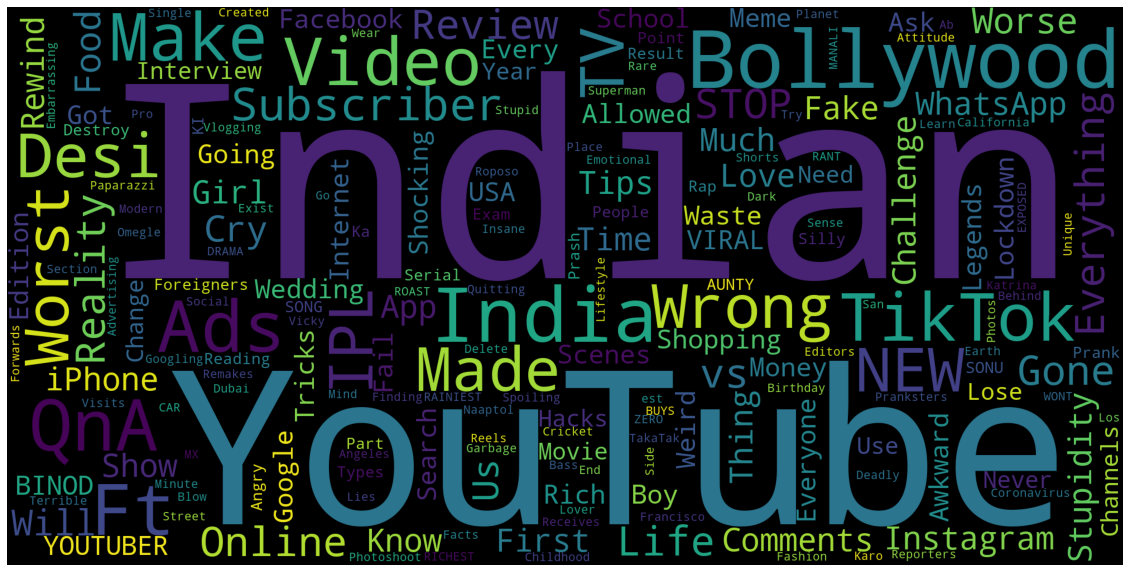

In [24]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(20, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

The channel strategy is to use "Indian" and other viral social media's keywords in the title of the video to attract and maximize the indian  audience  





### Channel's Journey

In [109]:
#first video
video_df.sort_values('publishedAt',ascending=True).head(1)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishDayName,durationSecs,durationMin,tagCount,publishedMonth,publishedYear
144,XCPzhbz_3yc,Slayy Point,How Much Do People Know About The IPL? | 2016,Are you crazy about the IPL too? But can you a...,"[CRICKET, quiz, knowledge, sports, Indian Prem...",2016-04-22 08:11:03+00:00,1273010,70514,None,5475,PT3M58S,hd,false,Friday,238.0,3.966667,16,4,2016


The first video on channel was uploaded on 22-04-2016

### Channel's growth with each year

Text(0, 0.5, 'views')

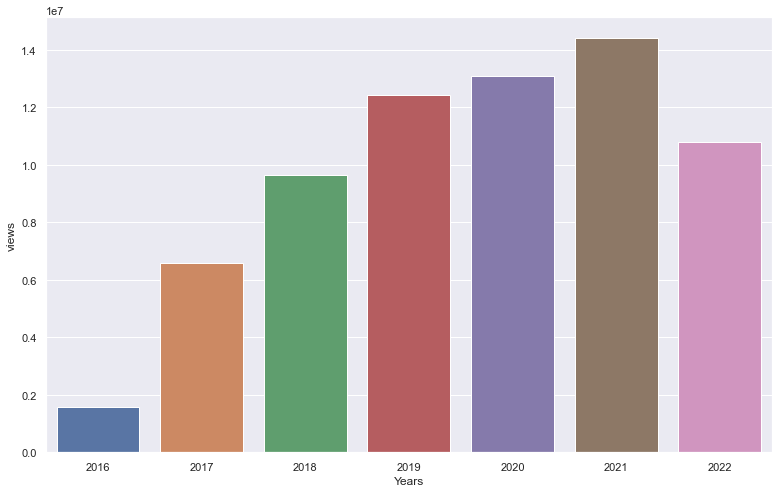

In [74]:
sns.set(rc={'figure.figsize':(13,8)})
ax = sns.barplot(x= np.array([2016,2017,2018,2019,2020,2021,2022]) , y='viewCount' , 
                 data=video_df.groupby('publishedYear').mean())

plt.xlabel('Years')
plt.ylabel('views')

### Comparison of Performance for this Year to the last two years

Text(0, 0.5, 'views')

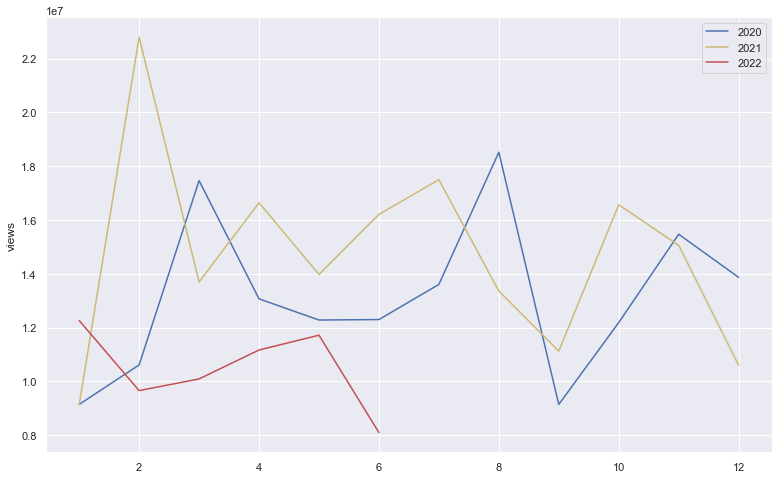

In [75]:
sns.set(rc={'figure.figsize':(13,8)})
 
#2020
ax = sns.lineplot(x= np.array([1,2,3,4,5,6,7,8,9,10,11,12]) , y='viewCount' , 
                data =  video_df.loc[video_df['publishedYear'] == 2020].groupby('publishedMonth').mean() ,
                color='b' ,label='2020')
#2021
ax = sns.lineplot(x= np.array([1,2,3,4,5,6,7,8,9,10,11,12]) , y='viewCount' , 
                data =  video_df.loc[video_df['publishedYear'] == 2021].groupby('publishedMonth').mean(),
                color='y' ,label='2021')

#2022
ax = sns.lineplot(x= np.array([1,2,3,4,5,6]) , y='viewCount' , 
                data =  video_df.loc[video_df['publishedYear'] == 2022].groupby('publishedMonth').mean(),
                color='r' ,label='2022')
plt.ylabel('views')

This year's average monthly views curves are significantly lesser,because as this year videos are new

### Channel's Growth With Each Video 

Text(0.5, 0, 'Videos Number')

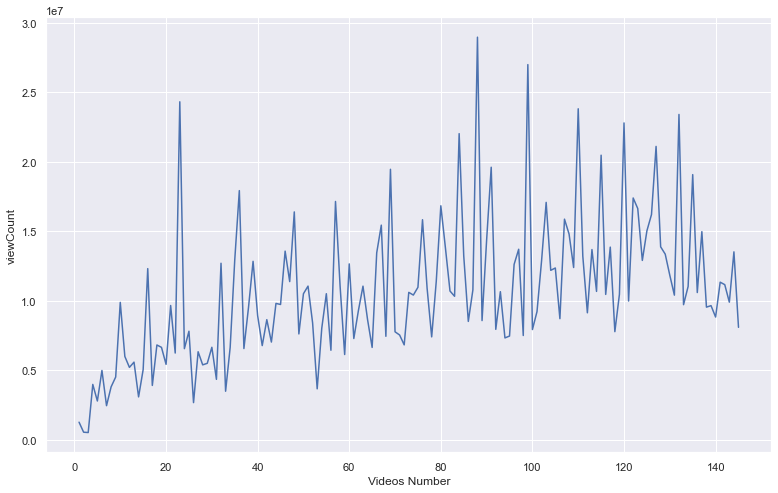

In [34]:
sns.set(rc={'figure.figsize':(13,8)})
ax = sns.lineplot(x=range(1,146)  , y='viewCount' , data=video_df.sort_values('publishedAt',ascending=True))
#plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#plot = ax.set_xticks(range(1,146))
plt.xlabel('Videos Number')

As we can see in the plot, They gets their first viral moment from their's 10th video that nearly touched 10 million.


### Analysis of Channel's First Viral Video 

Title- ''Funny Indian Ads ft. Technical Guruji , their first viral also video  had 'Indian' word in its title. 

In [34]:
#it's the 10th video so subtracting 9 from total no. of videos i.e. 144
video_df.iloc[144-9]

video_id                                                8qOuuYXRsLk
channelTitle                                            Slayy Point
title                                      INDIAN ADS HAVE NO LOGIC
description       Funny Indian Ads ft. Technical Guruji\n\nYOU C...
tags              [funny indian ads, indian ads, worst indian ad...
publishedAt                               2017-08-04 11:06:53+00:00
viewCount                                                   9887342
likeCount                                                    464196
favouriteCount                                                 None
commentCount                                                  11989
duration                                                    PT7M46S
definition                                                       hd
caption                                                       false
publishDayName                                               Friday
durationSecs                                    

### Videos Performance

### Top-10 videos 

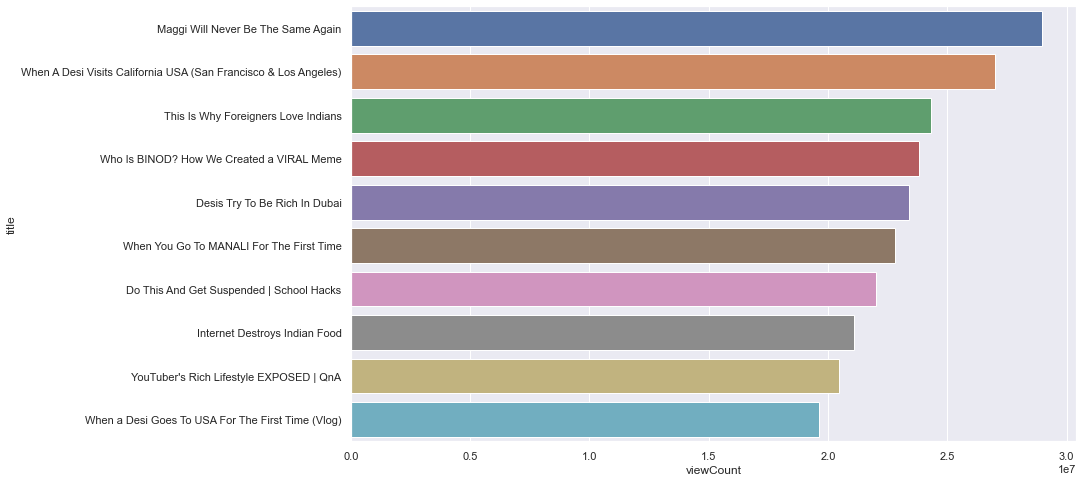

In [35]:
sns.set(rc={'figure.figsize':(13,8)})
ax = sns.barplot(x='viewCount' , y='title' , data=video_df.sort_values('viewCount', ascending=False)[0:10])
#plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

###  Top 10 worst ( viewcount wise ) Videos that didn't peform relatively well

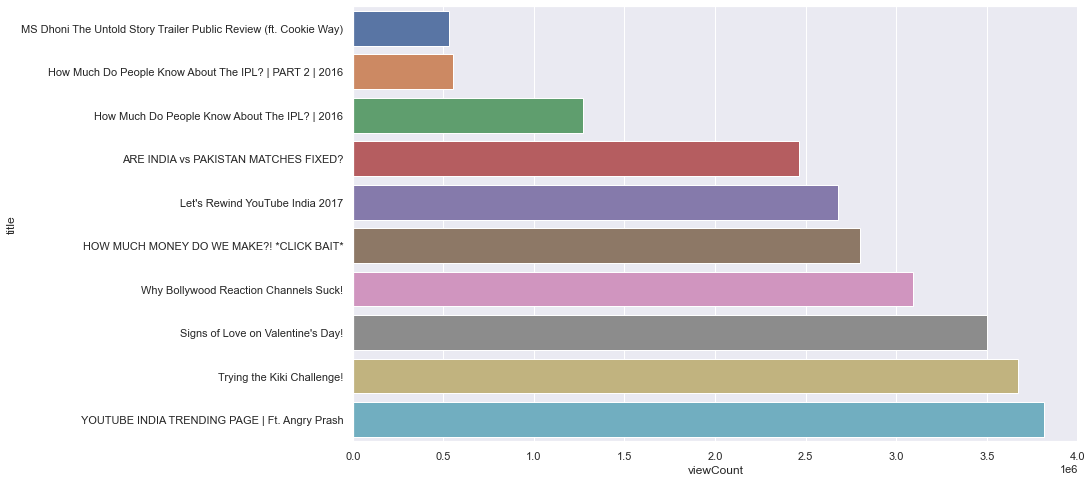

In [36]:
sns.set(rc={'figure.figsize':(13,8)})
ax = sns.barplot(x='viewCount' , y='title' , data=video_df.sort_values('viewCount', ascending=True)[0:10])
#plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### Comparison of Top 10 Best and Worst Average Video's Duration

In [40]:
#Top 10 Videos that doesn't Peformed well
video_df.sort_values('viewCount', ascending=True)[0:10].mean(axis=0)

C:\Users\Dell\AppData\Local\Temp\ipykernel_5432\248465111.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  video_df.sort_values('viewCount', ascending=True)[0:10].mean(axis=0)
C:\Users\Dell\AppData\Local\Temp\ipykernel_5432\248465111.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  video_df.sort_values('viewCount', ascending=True)[0:10].mean(axis=0)


viewCount         2436869.30
likeCount          151037.90
favouriteCount           NaN
commentCount         6216.50
durationSecs          319.20
durationMin             5.32
tagCount               10.80
dtype: float64

In [39]:
#Top 10 Videos
video_df.sort_values('viewCount', ascending=False)[0:10].mean(axis=0)

C:\Users\Dell\AppData\Local\Temp\ipykernel_5432\3371415378.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  video_df.sort_values('viewCount', ascending=False)[0:10].mean(axis=0)
C:\Users\Dell\AppData\Local\Temp\ipykernel_5432\3371415378.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  video_df.sort_values('viewCount', ascending=False)[0:10].mean(axis=0)


viewCount         2.333700e+07
likeCount         1.000192e+06
favouriteCount             NaN
commentCount      7.031750e+04
durationSecs      8.122000e+02
durationMin       1.353667e+01
tagCount          7.800000e+00
dtype: float64

##### >> The average duration of the videos that doesn't peform very well was arrounfd 5:30 minutes and the videos duration that peformed well was 13:30 minutes

### Correlations

In [110]:
corr = video_df[['viewCount' , 'likeCount','commentCount','durationSecs','tagCount' ]].corr()
corr

,viewCount,likeCount,commentCount,durationSecs,tagCount
viewCount,1.000000,0.879171,0.385249,0.478036,-0.211906
likeCount,0.879171,1.000000,0.529468,0.593282,-0.263589
commentCount,0.385249,0.529468,1.000000,0.180820,-0.079993
durationSecs,0.478036,0.593282,0.180820,1.000000,-0.172606
tagCount,-0.211906,-0.263589,-0.079993,-0.172606,1.000000


<AxesSubplot:>

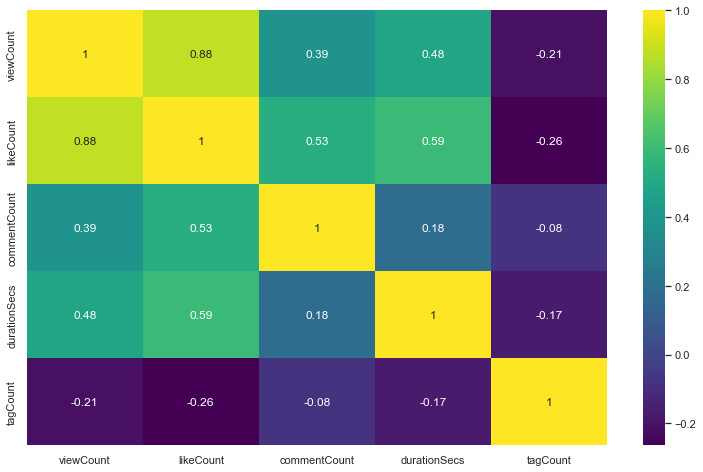

In [115]:
sns.set(rc={'figure.figsize':(13,8)})
sns.heatmap(corr, annot = True, cmap = 'viridis')

### Views, likes, comment and tags relation

### Number of likes vs. views

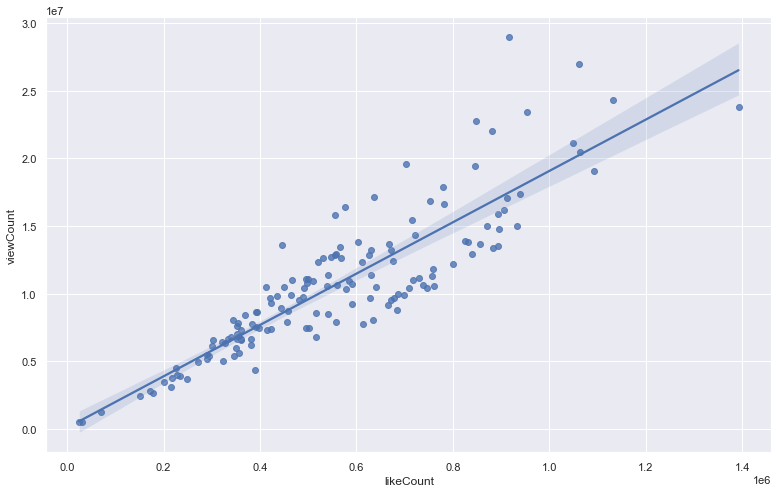

In [46]:
sns.set(rc={'figure.figsize':(13,8)})
ax = sns.regplot(x='likeCount', y= 'viewCount' , data=video_df)

the outlier is the video with highest view count and relatively less likes

### Number of Comment vs views

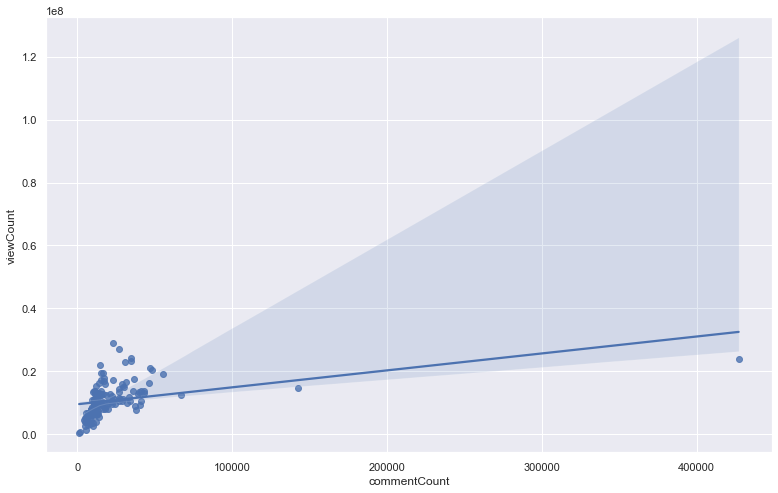

In [47]:
sns.set(rc={'figure.figsize':(13,8)})
ax = sns.regplot(x='commentCount', y= 'viewCount' , data=video_df)

### Number of Tags vs views

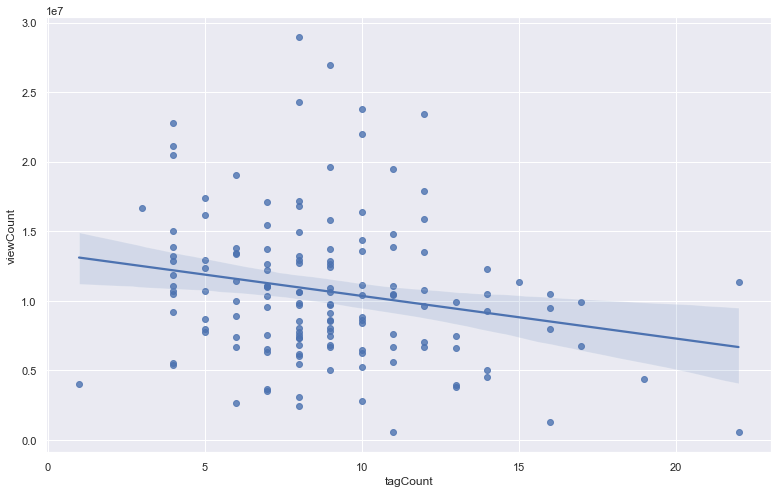

In [114]:
sns.set(rc={'figure.figsize':(13,8)})
ax = sns.regplot(x='tagCount', y= 'viewCount' , data=video_df)

### Length of the video and number of views

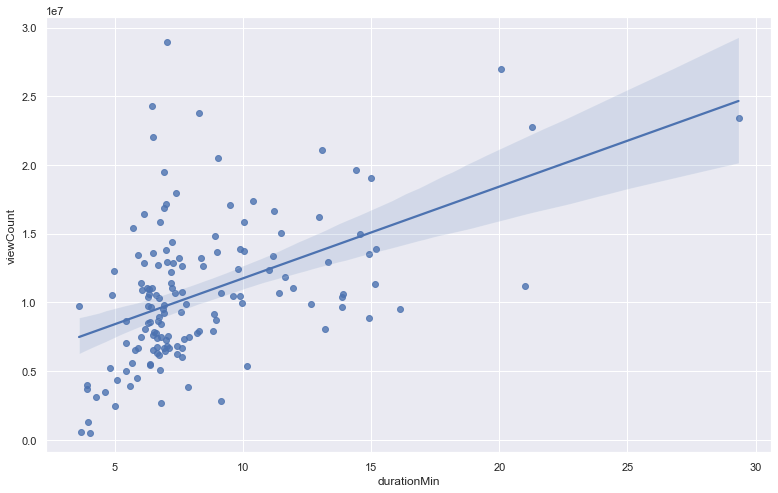

In [45]:
sns.set(rc={'figure.figsize':(13,8)})
ax = sns.regplot(x='durationMin', y= 'viewCount' , data=video_df)
#plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### Length of the title and number of views

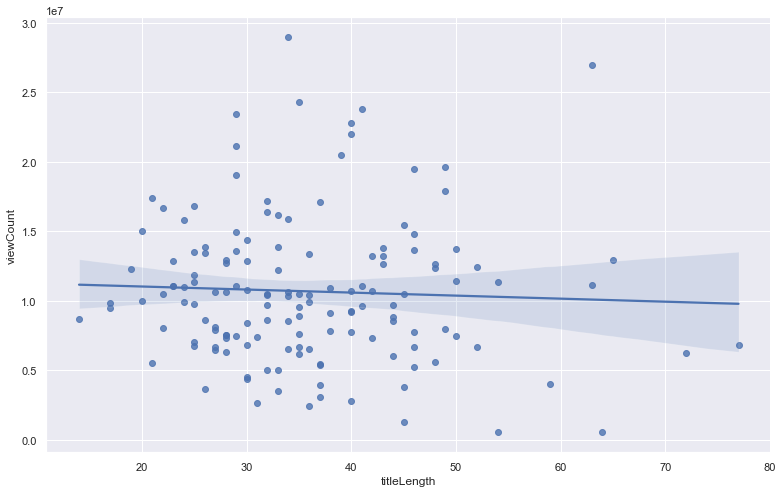

In [62]:
sns.set(rc={'figure.figsize':(13,8)})
ax = sns.regplot(x='titleLength' ,  y= 'viewCount' , data=video_df)

### Upload Schedule

##### Weekly schedule

Text(0, 0.5, 'Number of Videos uploaded')

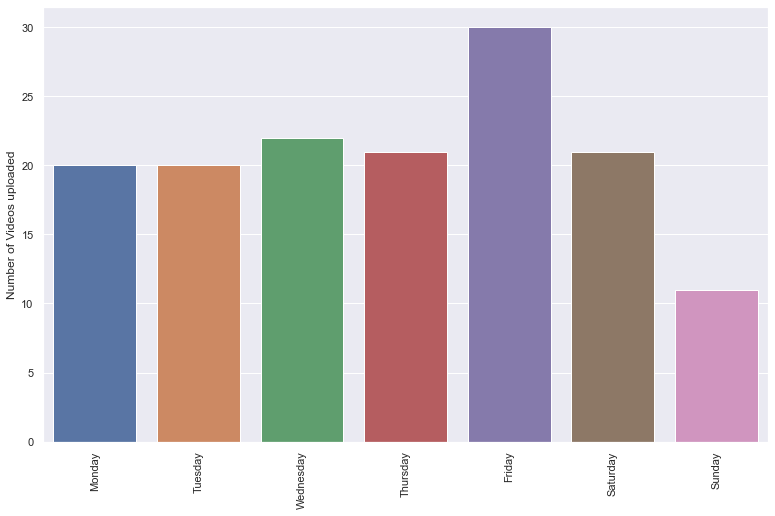

In [44]:
sns.set(rc={'figure.figsize':(13,8)})

weekdays = np.array([ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

ax = sns.barplot( x = np.array([ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
                 , y='viewCount' , data=video_df.groupby('publishDayName').count().reindex(weekdays))
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.ylabel('Number of Videos uploaded')

## Comment Analysis

In [39]:
comments_df

,video_id,comments
0,DyHS2H05AQc,[Download Groww app--- https://app.groww.in/v3...
1,D6qo8kSDlvE,[U GUYS ARE ACTUALLY TAKING IDEA FROM NISCHAY ...
2,c1NYunE_4t4,"[Omg hilarious 🤣, Ladki hai ki kutti - best, O..."
3,t7gA1Qtl1wY,[Happy Earth Day everyone!🌍\nPlease help us co...
4,mgrEg8hBJyU,[SUBSCRIBE-BUTTON TOUCHING VIDEO!\nToh jaldi s...
...,...,...
140,ZQxz3tRdlco,[Silly Point is now Slayy Point! A minor chang...
141,53IBdnidxtc,[Silly Point is now Slayy Point! A minor chang...
142,ircFZIzYlM8,[suddenly found this video ❤️❤️❤️❤️after slay ...
143,QBZPhIuDcNo,"[BINOD, Anand, 0:25 uncle op 😂\nBro \nIndian p..."


#### WordCloud for Comments

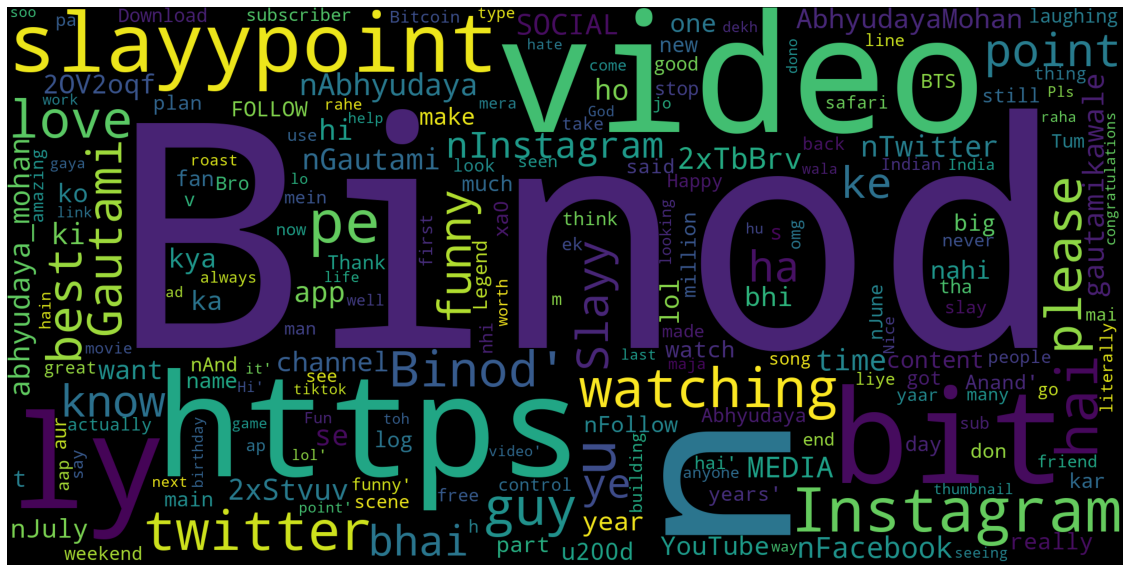

In [77]:
stop_words = set(stopwords.words('english'))
comments_df['comments_no_stopwords'] = comments_df['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comments_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(20, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)


1)Binod

Well !!!!, who don't know about legendary Binod

Slayy Point were the one who gave us this legendary meme and literally comments section of all videos on the social media got filled and spammed with 'Binod'
.
To any question,the answer remained same - 'Binod'

2)https

it is because as we extracted only the first 10 comments (due to quote limit of Youtube API) and in most of the videos they have sponsors so they put sponsors website in the pinned comment (at the top)